In [1]:
import MDAnalysis
from glob import glob
import os
import subprocess
import pandas as pd

In [13]:
pdb_files = glob('./1pfk_ABCD_protein.pdb')
pdb_files.sort()

In [14]:
u = MDAnalysis.Universe(pdb_files[0])
u.select_atoms('chainID A and (resnum 21 or resid 25)').residues.resnames

array(['ARG', 'ARG'], dtype=object)

In [15]:
def get_initial_position(pdb_file):
    u = MDAnalysis.Universe(pdb_file)
    sel = u.select_atoms('chainID A and (resnum 21 or resid 25)')

    return sel.center_of_mass()

In [16]:
def clean_pdb(pdb_file, out_file):
    u = MDAnalysis.Universe(pdb_file)
    sel = u.select_atoms('protein')
    sel.write(out_file, bonds=None)

In [17]:
def make_complex_pdb(protein_file, ligand_file, out_file):
    subprocess.call(['cat', protein_file, ligand_file], stdout=open(out_file, 'w'))

In [18]:
def write_dock_xml(template_xml, initial_pos, path):

    with open(template_xml, 'r') as f:
        lines = f.readlines()
    
    for i,line in enumerate(lines):
        if line.startswith('\t\t\t\t<Coordinates x="xx" y="xx" z="xx"/> \n'):
            lines[i] = f'''\t\t\t\t<Coordinates x="{initial_pos[0]}" y="{initial_pos[1]}" z="{initial_pos[2]}"/> \n'''
            break
    if i == len(lines)-1:
        print(lines)
        print('Coordinates not found')
        raise ValueError
    with open(path, 'w') as f:
        f.writelines(lines)

In [19]:
def write_dock_flag(complex_pdb, xml_file, ouput_dir, flag_file):
    flags = f'''
    -in
        -file
            -s {complex_pdb} # complex pdb
            -extra_res_fa PEP.params
    -packing
        -ex1
        -ex2
        -no_optH false
        -flip_HNQ true
        -ignore_ligand_chi true
        
    -parser
        -protocol {xml_file} # docking protocol

    -out
        -overwrite 
        -path:all {ouput_dir}
        -nstruct 500
    -mistakes
        -restore_pre_talaris_2013_behavior true
    -run 
        -ignore_zero_occupancy false #gmx 产生的pdb都需要设置
    
    '''
    with open(flag_file, 'w') as f:
        f.write(flags)
        


In [20]:
initial_pos = get_initial_position(pdb_files[0])

In [21]:
initial_pos

array([14.72290257,  2.09485485, 18.00265773])

In [22]:
# make output directory if not exist and skip if exist
if not os.path.exists('output'):
    os.mkdir('output')


def run_docking(pdb_file):
    case_name = pdb_file.split('/')[-1].split('.')[0]

    ouput_dir = f'./output/{case_name}'
    if not os.path.exists(ouput_dir):
        os.mkdir(ouput_dir)

    cleaned_pdb_file = f'{ouput_dir}/{case_name}_clean.pdb'
    clean_pdb(pdb_file, cleaned_pdb_file)
    complex_pdb_file = f'{ouput_dir}/{case_name}_complex.pdb'
    make_complex_pdb(cleaned_pdb_file, './PEP_0001.pdb', complex_pdb_file)

    initial_pos = get_initial_position(pdb_file)

    dock_xml_file = f'{ouput_dir}/dock_{case_name}.xml'
    write_dock_xml('./dock.xml', initial_pos, dock_xml_file)

    dock_flags_file = f'{ouput_dir}/dock_{case_name}.flags'
    write_dock_flag(complex_pdb_file,
                     dock_xml_file, 
                     ouput_dir,
                     dock_flags_file)
    # run docking and redirect output to log file 
    log_file = f'{ouput_dir}/dock_{case_name}.log'
    with open(log_file, 'w') as f:
        subprocess.run([f'rosetta_scripts.mpi.linuxgccrelease', f'@{dock_flags_file}'],
                        stdout=f,
                        stderr=f)

In [23]:
from joblib import Parallel, delayed

# In main function
Parallel(n_jobs=1)(delayed(run_docking)(pdb_file) for pdb_file in pdb_files)

/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [118]:
def parse_line(raw_line, delimiter=' '):
    line = []
    for i in raw_line.strip().split(delimiter):
        if i != '':
            line.append(i)
    return line

def score2df(score_file):
    f = open(score_file)
    raw_data = f.readlines()
    f.close()
    data = []
    for i in raw_data[2:]:
        line = parse_line(i)
        data.append(line)
    cols = parse_line(raw_data[1])
    df = pd.DataFrame(data, columns=cols)
    df.iloc[:,1:-1] = df.iloc[:,1:-1].astype(float)
    df['interface_delta_X'] = df['interface_delta_X'].astype(float)
    return df

In [119]:
df = score2df('./output/1_Ga0374951_065662_199_1131_1_relax-min_cst_0038/score.sc')

/var/folders/jj/7d28rm8x3_1frkhmtn_0_3yc0000gn/T/ipykernel_16261/2404995741.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['interface_delta_X'], bins=100)


<Axes: xlabel='interface_delta_X', ylabel='Density'>

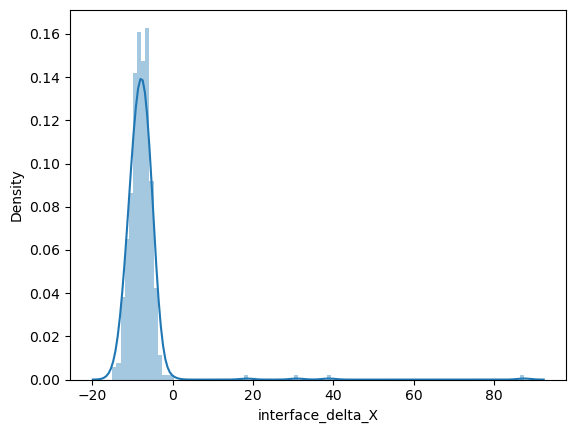

In [120]:
import seaborn as sns

sns.distplot(df['interface_delta_X'], bins=100)

In [121]:
top_10_df = df.sort_values('interface_delta_X').head(10).reset_index(drop=True)

In [122]:
top_10_df['description'][0]

'1_Ga0374951_065662_199_1131_1_relax-min_cst_0038_complex_0041'

In [123]:
df

,SCORE:,total_score,Grid_score,Transform_accept_ratio,angle_constraint,atom_pair_constraint,chainbreak,classic_grid_X,coordinate_constraint,dihedral_constraint,...,if_X_pro_close,if_X_ref,interface_delta_X,ligand_is_touching_X,omega,p_aa_pp,pro_close,ref,total_score_X,description
0,SCORE:,-977.24,-7.0,0.081,0.0,0.0,0.0,-52.0,1.071,0.0,...,0.0,0.0,-10.731,1.0,54.311,-54.584,2.217,-84.46,-52.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
1,SCORE:,-980.783,-39.0,0.089,0.0,0.0,0.0,-36.0,0.664,0.0,...,0.0,0.0,-7.957,1.0,53.837,-55.99,1.863,-84.46,-36.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
2,SCORE:,-984.09,-7.0,0.091,0.0,0.0,0.0,-36.0,0.824,0.0,...,0.0,0.0,-7.033,1.0,53.868,-55.896,1.892,-84.46,-36.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
3,SCORE:,-945.48,-16.0,0.07,0.0,0.0,0.0,-43.0,8.446,0.0,...,0.0,0.0,-12.687,1.0,56.765,-55.459,2.536,-84.46,-43.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
4,SCORE:,-984.068,-26.0,0.088,0.0,0.0,0.0,-41.0,1.155,0.0,...,0.0,0.0,-7.722,1.0,53.157,-56.033,1.879,-84.46,-41.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,SCORE:,-982.874,-27.0,0.072,0.0,0.0,0.0,-28.0,0.625,0.0,...,0.0,0.0,-4.683,1.0,53.454,-56.058,1.88,-84.46,-28.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
505,SCORE:,-978.728,-41.0,0.073,0.0,0.0,0.0,-40.0,0.119,0.0,...,0.0,0.0,-5.638,1.0,53.31,-56.199,1.88,-84.46,-40.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
506,SCORE:,-978.548,-3.0,0.079,0.0,0.0,0.0,-29.0,0.813,0.0,...,0.0,0.0,-3.519,1.0,52.95,-56.374,1.852,-84.46,-29.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...
507,SCORE:,-965.479,-36.0,0.091,0.0,0.0,0.0,-54.0,6.385,0.0,...,0.0,0.0,-11.847,1.0,54.108,-56.032,2.458,-84.46,-54.0,1_Ga0374951_065662_199_1131_1_relax-min_cst_00...


In [125]:
for pdb_file in pdb_files:
    case_name = pdb_file.split('/')[-1].split('.')[0]
    ouput_dir = f'./output/{case_name}'

    df = score2df(f'{ouput_dir}/score.sc')
    top_10_df = df.sort_values('interface_delta_X').head(10).reset_index(drop=True)

    print(f'{case_name} {top_10_df.mean(numeric_only=True)["interface_delta_X"]}')

    if not os.path.exists(f'./output_top10/{case_name}'):
        os.mkdir(f'./output_top10/{case_name}')
    
    for row in top_10_df.iterrows():
        pdb = row[1]['description'].split()[0] + '.pdb'
        subprocess.run(['cp', f'{ouput_dir}/{pdb}', f'./output_top10/{case_name}'])



1_Ga0374951_065662_199_1131_1_relax-min_cst_0038 -13.6129
2_top2_Ga0314781_057584_109_711_1_relax-min_cst_0018 -12.514999999999999
3_top2_TARA_100_MES_0 -13.1952
4_Ga0197551_01_5276904_5277770_1_relax-min_cst_0040 -9.3135
